## Qunatum Error Correction

One of the important aspects in Quantum computation/information is prevent loss of quantum state. The state is fragile and up until now, there's no guarantee for data intregity. The qunatum state is contingent to it's surrounding. Unless it's mitigated the quantum superiority would be a far fetched idea. At least on the state of the art Quantum computers phrased as Noisy Intermediate-Scale Quantum (NISQ). All NISQ devices are plagued by decoherence phenomenon.

In this notebook, QEC is explored and mitigated for three qubit system. First attention would be towards the bit-flip and next would be sign-flip. A quantum error correction consists of four major steps: encoding, error detection, error recovery, and decoding. These ideas are encapsulated by "Figure 1"

<figure>
<img src="assets/images/fig1.png" alt="QEC circuit" width="500"/>
<figcaption><b>Figure 1 - A schematic for Quantum error correction.</b></figcaption>
</figure>

The sender encodes the information on qubits via "Encoder" and sends it through the noisy "Quantum channel". During which the encoded qubits is exposed to possible bit flip or sign flip due to environmental factors. If the state encounters bit flip error then it means the qubit changed from state $|0\rangle$ to $|1\rangle$ or vice versa. During the sign flip error, the qubit undergoes phase change by $\pi$. The receiver now goes through all the hassle to detect the error (syndrome measurement), seggregate the noise and decode the information from the qubits. 

## 1. Three qubit bit flip

The 3-qubit bit-flip code is simple and a fundamental notion, hence it has been used as a gateway to quantum error correction. The 3-qubit flip code sends the same qubit three times, and therefore represents the repetition code equivalent. The corresponding codewords in this code are $|000\rangle$ and $|111\rangle$. Three qubits encodes the data from the sender. Once the receiver has the qubits. Two more qubits are placed as ancillary qubits. They become handy for the syndrome measurement.

### 1.1 Encoding

Actually the sender wants to tranfer the data present in one single qubit. The two extra qubits are added for redundancy, which helps to identify the bit flip error. This is called encoding. It's noteworthy that the state after encoding is $\alpha|000\rangle + \beta|111\rangle$, whereas the intial state is $(\alpha|0\rangle + \beta|1\rangle)\bigotimes(|00\rangle)$. The qiskit implementation of such is performed below.

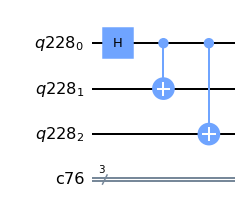

In [86]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute, Aer, BasicAer
from qiskit.visualization import plot_histogram

%matplotlib inline

qubit = QuantumRegister(3)
bit = ClassicalRegister(3)

qc = QuantumCircuit()
qc.add_register(qubit, bit)
qc.h(0)
qc.cnot(0,1)
qc.cnot(0,2)

qc.draw('mpl')

In [87]:
from qiskit_textbook.tools import array_to_latex

backend = Aer.get_backend('statevector_simulator')

final_state = execute(qc,backend).result().get_statevector()
array_to_latex(final_state, pretext="\\text{Statevector} = ")

<IPython.core.display.Math object>

### 1.2 Random noise
Since there are three qubits, I divided the probability of bit-flip equally amongst them. The X-gate performs a bit flip operation. A histogram plot of the measurement 

Bit flip occured in third qubit


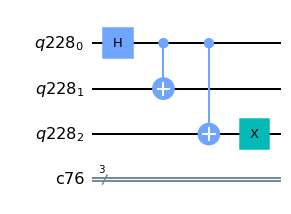

In [88]:
import random
chance = int(3.*random.random())
index = 0
if (chance == 0):
    qc.x(0)
    print ("Bit flip occured in first qubit")
elif (chance == 1):
    print ("Bit flip occured in second qubit")
    qc.x(1)
    index = 1
else:
    print ("Bit flip occured in third qubit")
    qc.x(2)
    index = 2
qc.draw('mpl')

### 1.3 Syndrome measurement

Before decoding the precious information encoded int the qubit, the receiver needs to check for any error that could have occured during the transmission. Since the measurement of qubits will destroy the information it holds, it's a smart idea to transfer the information, including any error due to the channel, of encoded qubit onto two ancillary qubits. Once set up, these ancillary qubits can tell the error syndrome and by consulting the look up table (Table 1, situated in the succeeding section). Finally, an appropriate X-gate can be applied to the qubit which suffered a bit flip.

The qiskit code and the circuit to perform syndrome measurement is shown below.

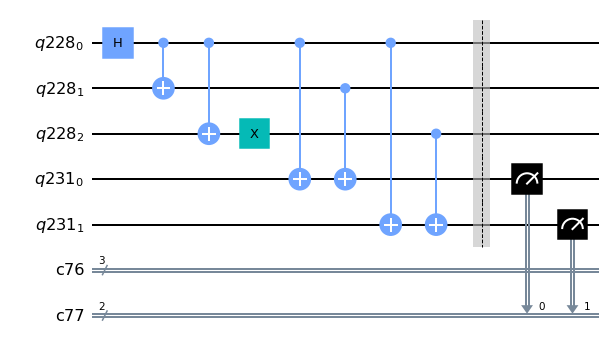

In [89]:
from qiskit.aqua.operators import StateFn

qubit_anc = QuantumRegister(2)
bit_anc = ClassicalRegister(2)

qc.add_register(qubit_anc, bit_anc)

qc.cnot(0,3)
qc.cnot(1,3)
qc.cnot(0,4)
qc.cnot(2,4)

qc.barrier()

backend = BasicAer.get_backend('qasm_simulator')
qc.measure(qubit_anc, bit_anc)

qc.draw('mpl')

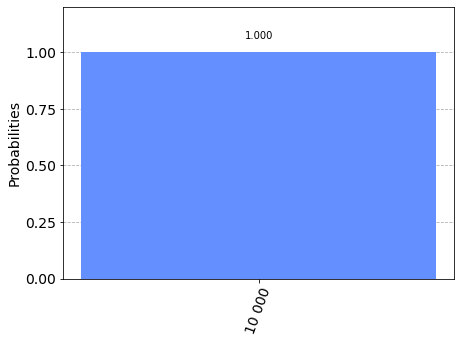

In [90]:
job = execute(qc, backend, shots=1024)
counts = job.result().get_counts(qc)

plot_histogram(counts)

### 1.4 Look up table (LUT)
<figure>
<img src="assets/images/LUT.png" alt="QEC circuit" width="500"/>
<figcaption><b>Table 1 - The quantum state of the circuit after syndrome measurement. Refer [2] on the reference section at the end of this notebook </b></figcaption>
</figure>

From the preceding section it's clear the state of ancillary qubit is $|01\rangle$. The LUT suggests the third qubit has suffered a bit filp. 

### 1.5 Error correction
This can be easily mitigated with the application of X-gate on it. Since $\sigma_{x}\sigma_{x} = I = \sigma_{x}^2$, the second application of X-gate will culminate in identity operation. Application of X-gate on second qubit is executed below. Moreover, the implicated circuit is drawn for a visual cue. There must be two X-gate along the line, running throughtout circuit depth, for qubit that suffered but flip.

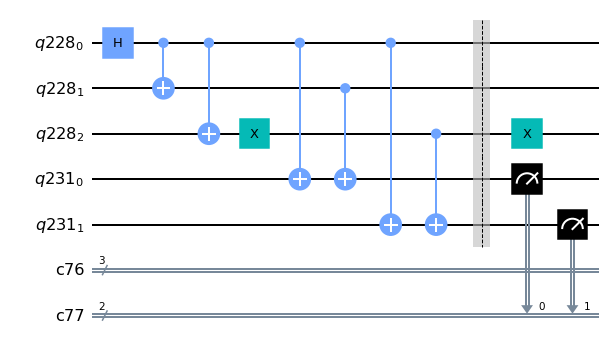

In [91]:
qc.x(index)
qc.draw('mpl')

### 1.6 Decoding

It is inverse of Encoding. Thus it reverse the effect of encoding and put the circuit at the initial state which is $(\alpha|0\rangle + \beta|1\rangle)\bigotimes(|00\rangle)$. For the decoding operation, the gates used for encoding is now mirrored.

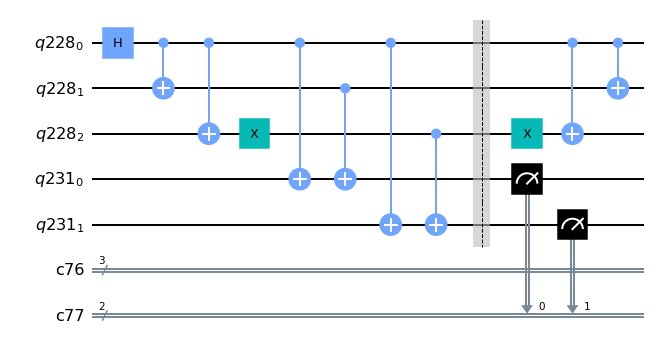

In [92]:
qc.cnot(0,2)
qc.cnot(0,1)

qc.draw('mpl')

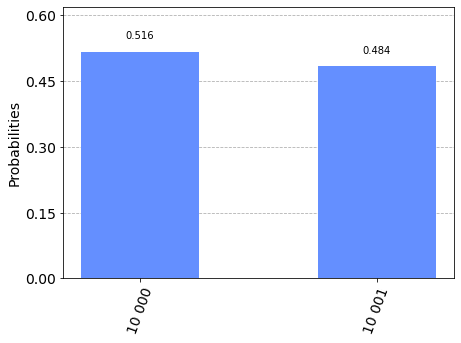

In [93]:
qc.measure(qubit, bit)
job = execute(qc, backend, shots=1024)
counts = job.result().get_counts(qc)

plot_histogram(counts)

### 1.7 Result

The measurement for the first qubit shows it's in the initial quantum state ($(\alpha|0\rangle + \beta|1\rangle)\bigotimes(|00\rangle)$). The bit flip error was introduced to the circuit, after that the mitigitation was successfully carried out.

## 2. Three qubit phase flip

Phase flip is another type of decoherence error on quantum devices. It's similar to the preceding bit flip error except that the flip occurs along the X-axis. In other words, the bit flip occurs on Hadamard basis i.e., $|+\rangle = \frac{1}{\sqrt{2}}\left(|0\rangle + |1\rangle\right)$ and $|-\rangle = \frac{1}{\sqrt{2}}\left(|0\rangle - |1\rangle\right)$. This also means the quantum states needs to be prepared on the Hadamard basis instead of the computational basis. Back to the bit flip, the flip occurred in computational basis i.e., $|0\rangle$ and $|1\rangle$.

The upcoming proceedings would align to the bit flip section. Except the gate for error mitigation. Since the sign flip error means the qubit has gone bit flip around the Hadamard basis, the correcting gate will be Z-gate. Just like X-gate, it is involutory matrix i.e, $\sigma_{z}\sigma_{z} = I= \sigma_{z}^2$

### 2.1 Phase flip

The bit flip section suffices for one who seeks to understand the Quantum error. So, in this section I am going to demonstrate the qiskit circuit and the Look up table (LUT).

Sign flip occured in first qubit


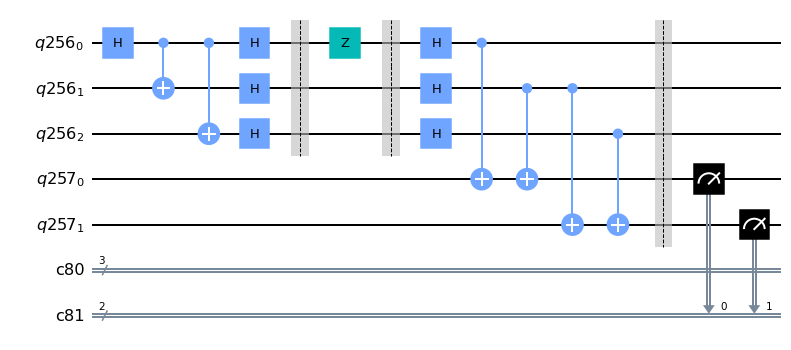

In [98]:
qubit = QuantumRegister(3)
bit = ClassicalRegister(3)

qc = QuantumCircuit()
qc.add_register(qubit, bit)
qc.h(0)
qc.cnot(0,1)
qc.cnot(0,2)

qc.h(qubit)

qc.barrier()
chance = int(3.*random.random())
index = 0
if (chance == 0):
    qc.z(0)
    print ("Sign flip occured in first qubit")
elif (chance == 1):
    print ("Sign flip occured in second qubit")
    qc.z(1)
    index = 1
else:
    print ("Sign flip occured in third qubit")
    qc.z(2)
    index = 2
    
qc.barrier()
qc.h(qubit)

qubit_anc = QuantumRegister(2)
bit_anc = ClassicalRegister(2)

qc.add_register(qubit_anc, bit_anc)

qc.cnot(0,3)
qc.cnot(1,3)
qc.cnot(1,4)
qc.cnot(2,4)

qc.barrier()
backend = BasicAer.get_backend('qasm_simulator')
qc.measure(qubit_anc, bit_anc)

qc.draw('mpl')

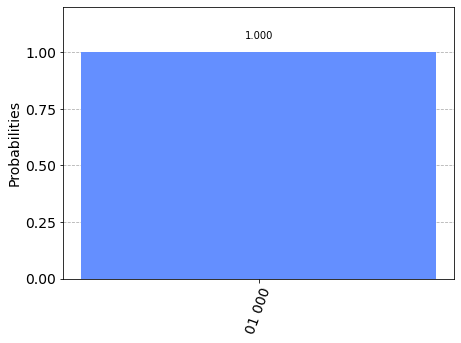

In [99]:
job = execute(qc, backend, shots=1024)
counts = job.result().get_counts(qc)

plot_histogram(counts)

### 2.2 Look up table (LUT)

<figure>
<img src="assets/images/LUTsign.png" alt="QEC circuit" width="500"/>
<figcaption><b>Table 1 - The quantum state of the circuit after syndrome measurement. Refer [5] on the reference section at the end of this notebook </b></figcaption>
</figure>

The LUT suggests there's a sign flip in first qubit. So a Z-gate on it will erase the error.

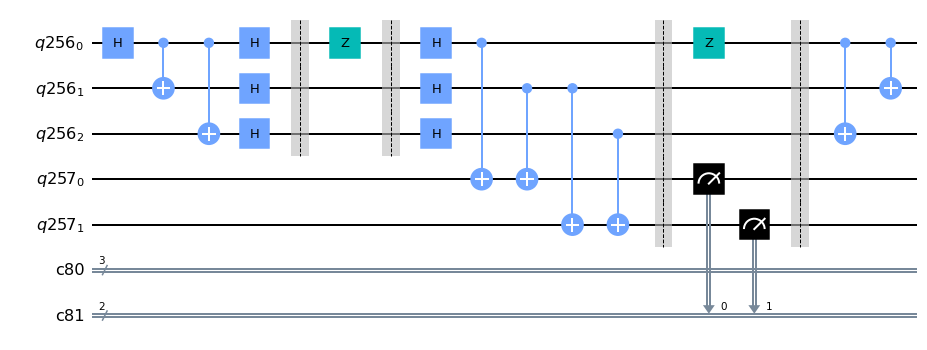

In [100]:
qc.z(index)
qc.barrier()
qc.cnot(0,2)
qc.cnot(0,1)

qc.draw('mpl')

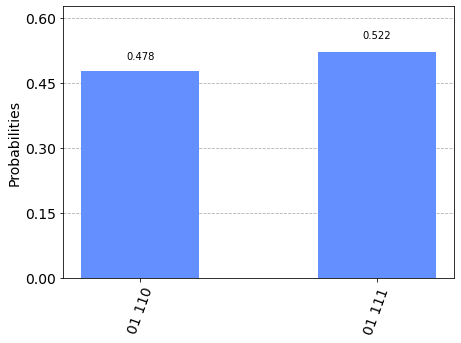

In [101]:
qc.measure(qubit, bit)
job = execute(qc, backend, shots=1024)
counts = job.result().get_counts(qc)

plot_histogram(counts)

## References

1. Djordjevic, I. (2021). Chap. 8. Quantum Error Correction. In Quantum information processing, quantum computing, and quantum error correction: An engineering approach. essay, Elsevier, AP, Academic Press. 
2. Devitt, S. J., Munro, W. J., & Nemoto, K. (2013). Quantum error correction for beginners. Reports on Progress in Physics, 76(7), 076001.
3. Vermersch, B., n.d. Quantum Error Correction (QEC). [online] Bvermersch.github.io. Available at: <https://bvermersch.github.io/Teaching/QO_Lecture3.pdf> [Accessed 12 September 2021].
4. Steane, A., 2006. A Tutorial on Quantum Error Correction. [online] Www2.physics.ox.ac.uk. Available at: <https://www2.physics.ox.ac.uk/sites/default/files/ErrorCorrectionSteane06.pdf> 
5. Djordjevic, I. (2021). Sec. 8.2.2. Quantum Error Correction Concepts. In Quantum information processing, quantum computing, and quantum error correction: An engineering approach. essay, Elsevier, AP, Academic Press. 